<a href="https://colab.research.google.com/github/ksnugroho/feel-in/blob/main/model-baseline-machine-learning/LA001_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model**

**Thesis: Emotion Detection in Indonesian Text**

Kuncahyo Setyo Nugroho<br>
Supervisor:
1. Dr. Eng. Fitra A. Bachtiar, S.T., M.Eng.
2. Prof. Ir. Wayan Firdaus Mahmudy, S.Si., M.T., Ph.D.

Faculty of Computer Science, Brawijaya University, Indonesia &copy; 2021-2022

# 01 Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Code/tesis

/content/drive/.shortcut-targets-by-id/1of66RueJPg6brfoSy1p4Wv3bofi-IrI5/tesis


In [ ]:
# https://github.com/intel/scikit-learn-intelex
!pip install -q scikit-learn-intelex==2021.5.3

     |████████████████████████████████| 69 kB 5.8 MB/s 
     |████████████████████████████████| 22.6 MB 1.1 MB/s 
     |████████████████████████████████| 284.3 MB 2.0 kB/s 
     |████████████████████████████████| 4.0 MB 75.4 MB/s 


In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

SEED = 50
FOLDER_PATH = 'model-baseline-machine-learning'
DATASET = 'final-tweet-lexicon-annotation'

np.random.seed(SEED)

%matplotlib inline

In [ ]:
# https://github.com/wandb/wandb
!pip install -q wandb

     |████████████████████████████████| 1.9 MB 13.7 MB/s 
     |████████████████████████████████| 174 kB 48.9 MB/s 
     |████████████████████████████████| 184 kB 55.3 MB/s 
     |████████████████████████████████| 62 kB 963 kB/s 
     |████████████████████████████████| 173 kB 61.4 MB/s 
     |████████████████████████████████| 168 kB 64.5 MB/s 
     |████████████████████████████████| 168 kB 41.0 MB/s 
     |████████████████████████████████| 166 kB 73.8 MB/s 
     |████████████████████████████████| 166 kB 44.9 MB/s 
     |████████████████████████████████| 162 kB 77.0 MB/s 
     |████████████████████████████████| 162 kB 79.6 MB/s 
     |████████████████████████████████| 158 kB 76.8 MB/s 
     |████████████████████████████████| 157 kB 67.1 MB/s 
     |████████████████████████████████| 157 kB 56.1 MB/s 
     |████████████████████████████████| 157 kB 70.8 MB/s 
     |████████████████████████████████| 157 kB 54.0 MB/s 
     |████████████████████████████████| 157 kB 64.0 MB/s 
     |██████████

In [ ]:
import wandb
from wandb.sklearn import plot_confusion_matrix, plot_precision_recall, plot_class_proportions, plot_learning_curve, plot_roc, plot_summary_metrics

os.environ['WANDB_MODE'] = 'online' # mode: disabled, online, offline
os.environ['WANDB_NOTEBOOK_NAME'] = f'{FOLDER_PATH}/LA001-machine-learning.ipynb'

wandb.login(key='bd42e3aab9cac21a2416900b1114532802619de3')

WANDB_PROJECT = 'model-baseline-machine-learning'
WANDB_ENTITY = 'indoemobert'

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 02 Load Data (Lexicon Based Annotation)

In [ ]:
df = pd.read_csv('data/final-tweet-lexicon-annotation.csv', index_col=0)
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)   # For shuffle
print(df.head())

                                               tweet  label
0        wah belom liat muka gue lagi murka hahahaha  anger
1  Mungkin kurang piknik adrenalin. Mereka yg ske...  anger
2  maaf kalo tersinggung "orang kurus cepet mati"...  anger
3  berserah pada maha esa paling tabah dan sabar ...    joy
4                       Ehekk malu la hahahahahahaha   fear


In [ ]:
# df = df.dropna()

In [ ]:
df.shape

(2243, 2)

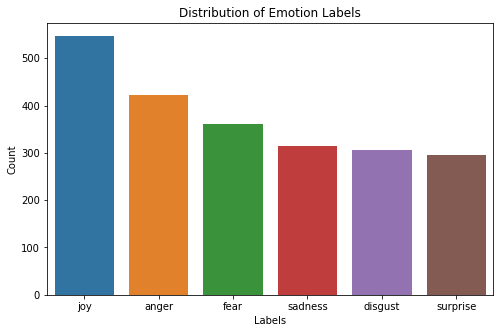

anger       422
disgust     305
fear        360
joy         547
sadness     314
surprise    295
Name: label, dtype: int64

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()

df['label'].value_counts().sort_index()

# 03 Preprocessing

## Text Cleaning

In [ ]:
def text_cleaning(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces

  return text

In [ ]:
%%time
df['tweet'] = df['tweet'].progress_apply(text_cleaning)

100%|██████████| 2243/2243 [00:00<00:00, 42096.19it/s]

CPU times: user 61.1 ms, sys: 2.08 ms, total: 63.2 ms
Wall time: 62.9 ms


## Label Encoder

In [ ]:
le = LabelEncoder()

df['label_encode'] = le.fit_transform(df['label'])
print(df.head())

                                               tweet  label  label_encode
0        wah belom liat muka gue lagi murka hahahaha  anger             0
1  mungkin kurang piknik adrenalin mereka yg skep...  anger             0
2  maaf kalo tersinggung orang kurus cepet mati w...  anger             0
3  berserah pada maha esa paling tabah dan sabar ...    joy             3
4                       ehekk malu la hahahahahahaha   fear             2


In [ ]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


# 04 Feature Extraction & Feature Selection

## Term Frequency–Inverse Document Frequency (TF-IDF)

In [ ]:
X = df['tweet']
y = df['label_encode']

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tf_idf.fit(X)

TfidfVectorizer(ngram_range=(1, 2))

In [ ]:
full_vocab = tf_idf.vocabulary_

In [ ]:
X_tf_idf = tf_idf.transform(X).toarray()
print(X_tf_idf)
print(X_tf_idf.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2243, 39389)


## Chi-Square Test for Feature Selection

In [ ]:
K_FEATURES = 10000

chi2_features = SelectKBest(chi2, k=K_FEATURES) 
X_kbest_features = chi2_features.fit_transform(np.array(X_tf_idf), np.array(y)) 
  
print('Number of original features:', X_tf_idf.shape[1]) 
print('Number of features after selection:', X_kbest_features.shape[1]) 

Number of original features: 39389
Number of features after selection: 10000


In [ ]:
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['chi2_score'])
data_chi2['feature'] = tf_idf.get_feature_names_out()

data_chi2.sort_values(by='chi2_score', ascending=False).head(10)

,chi2_score,feature
15574,116.163705,jijik
25433,98.861730,ngeri
35466,82.241915,terkejut
13296,78.433084,heran
34426,51.761745,takut
35684,48.335712,terpesona
18311,47.152314,kesal
17534,42.154867,kecewa
12470,37.538384,gugup
32037,37.395829,senang


In [ ]:
selected_feature = []

# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
feature_mask = chi2_features.get_support()

for bool, f in zip(feature_mask, tf_idf.get_feature_names_out()):
  if bool:
    selected_feature.append(f)
  selected_feature = selected_feature

In [ ]:
selected_feature_vocab = {}

for (word,index) in tf_idf.vocabulary_.items(): 
  if word in selected_feature:           
    selected_feature_vocab[word] = index

# 05 Train & Test Data Splitting

In [ ]:
TEST_SIZE = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.20, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1794, 10000), (449, 10000), (1794,), (449,))

# 06 Modeling

In [ ]:
def truncate(n, decimals=0):
  multiplier = 10 ** decimals
  return int(n * multiplier) / multiplier

In [ ]:
# Define machine learning models
models = [
          ('KNN', KNeighborsClassifier()),
          ('NAIVE BAYES', MultinomialNB()),
          ('SVM', SVC(probability=True)),
          ('DECISION TREE', DecisionTreeClassifier())
        ]

In [ ]:
%%time

for name, model in models:
  print(f'\n[INFO] Loading using {name} ...\n')

  MODEL_NAME = type(model).__name__   
  MODEL_PARAMS = model.get_params()    

  wandb_run = wandb.init(project=f'{WANDB_PROJECT}',
                         name=f'{MODEL_NAME}',
                         entity=f'{WANDB_ENTITY}', 
                         config=MODEL_PARAMS,
                         save_code=True)

  clf = model.fit(X_train, y_train)

  y_pred = clf.predict(X_test)             
  y_prob = clf.predict_proba(X_test)       
  y_true = y_test

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))                        
  train_precision = precision_score(y_train, clf.predict(X_train), average='weighted')  
  train_recall = recall_score(y_train, clf.predict(X_train), average='weighted')        
  train_f1score = f1_score(y_train, clf.predict(X_train), average='weighted')           

  wandb.config.update({"dataset": DATASET,
      "full_feature": X_tf_idf.shape[1],
      "selected_feature": X_kbest_features.shape[1],
      "test_size": TEST_SIZE,
      "train_len": len(X_train),
      "test_len": len(X_test)})
  
  print(f'\n[INFO] {name} Cross validation:')
  cross_validation = ShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
  for i, score in enumerate(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_validation)):
    cv_accuracy_mean = score.mean()

    wandb.log({'cross_validation_score': score})

    print(f'\tAccuracy for the fold no. {i} on the test set: {truncate(score, 3)}')

  test_accuracy = accuracy_score(y_true, y_pred)                                        
  test_precision = precision_score(y_true, y_pred, average='weighted')                   
  test_recall = recall_score(y_true, y_pred, average='weighted')
  test_f1score = f1_score(y_true, y_pred, average='weighted')                        

  print(f'\n[INFO] {name} Training accuracy: {truncate(train_accuracy, 3)}')
  print(f'[INFO] {name} Training f1 score: {truncate(train_f1score, 3)}')
  print(f'[INFO] {name} Cross validation accuracy: {truncate(cv_accuracy_mean, 3)}')
  print(f'[INFO] {name} Testing accuracy: {truncate(test_accuracy, 3)}')
  print(f'[INFO] {name} Testing f1 score: {truncate(test_f1score, 3)}')
  print(f'[INFO] {name} Classfication report:\n {classification_report(y_pred, y_true, target_names=LABEL_NAME)}\n')

  wandb.log({'train_accuracy': train_accuracy, 
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1score': train_f1score,
            'cross_validation_accuracy': cv_accuracy_mean,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1score': test_f1score})
  
  plot_confusion_matrix(y_true, y_pred, LABEL_NAME)
  plot_class_proportions(y_true, y_test, LABEL_NAME)
  plot_roc(y_test, y_prob, LABEL_NAME)
  plot_precision_recall(y_test, y_prob, LABEL_NAME)
  plot_learning_curve(model, X_train, y_train)
  plot_summary_metrics(model, X_train, y_train, X_test, y_test)

  wandb_run.finish()

  print(f'[INFO] {name} Done ...')
print('\n[INFO] All done ...')

wandb: Currently logged in as: indoemobert. Use `wandb login --relogin` to force relogin



[INFO] Loading using KNN ...




[INFO] KNN Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.331
	Accuracy for the fold no. 1 on the test set: 0.306
	Accuracy for the fold no. 2 on the test set: 0.356
	Accuracy for the fold no. 3 on the test set: 0.359
	Accuracy for the fold no. 4 on the test set: 0.356
	Accuracy for the fold no. 5 on the test set: 0.348
	Accuracy for the fold no. 6 on the test set: 0.306
	Accuracy for the fold no. 7 on the test set: 0.32
	Accuracy for the fold no. 8 on the test set: 0.325
	Accuracy for the fold no. 9 on the test set: 0.328

[INFO] KNN Training accuracy: 0.535
[INFO] KNN Training f1 score: 0.48
[INFO] KNN Cross validation accuracy: 0.328
[INFO] KNN Testing accuracy: 0.336
[INFO] KNN Testing f1 score: 0.254
[INFO] KNN Classfication report:
               precision    recall  f1-score   support

       anger       0.56      0.40      0.46       131
     disgust       0.10      0.86      0.17         7
        fear       0.13      0.31      0.19        29
         joy  

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


cross_validation_accuracy,▁
cross_validation_score,▄▁███▇▁▃▄▄
test_accuracy,▁
test_f1score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1score,▁
train_precision,▁
train_recall,▁
cross_validation_accuracy,0.32869


[INFO] KNN Done ...

[INFO] Loading using NAIVE BAYES ...




[INFO] NAIVE BAYES Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.306
	Accuracy for the fold no. 1 on the test set: 0.337
	Accuracy for the fold no. 2 on the test set: 0.348
	Accuracy for the fold no. 3 on the test set: 0.415
	Accuracy for the fold no. 4 on the test set: 0.42
	Accuracy for the fold no. 5 on the test set: 0.406
	Accuracy for the fold no. 6 on the test set: 0.345
	Accuracy for the fold no. 7 on the test set: 0.339
	Accuracy for the fold no. 8 on the test set: 0.378
	Accuracy for the fold no. 9 on the test set: 0.331

[INFO] NAIVE BAYES Training accuracy: 0.715
[INFO] NAIVE BAYES Training f1 score: 0.729
[INFO] NAIVE BAYES Cross validation accuracy: 0.331
[INFO] NAIVE BAYES Testing accuracy: 0.38
[INFO] NAIVE BAYES Testing f1 score: 0.333
[INFO] NAIVE BAYES Classfication report:
               precision    recall  f1-score   support

       anger       0.30      0.90      0.45        31
     disgust       0.23      0.88      0.36        16
        fear

cross_validation_accuracy,▁
cross_validation_score,▁▃▄██▇▃▃▅▃
test_accuracy,▁
test_f1score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1score,▁
train_precision,▁
train_recall,▁
cross_validation_accuracy,0.33148


[INFO] NAIVE BAYES Done ...

[INFO] Loading using SVM ...




[INFO] SVM Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.593
	Accuracy for the fold no. 1 on the test set: 0.629
	Accuracy for the fold no. 2 on the test set: 0.568
	Accuracy for the fold no. 3 on the test set: 0.679
	Accuracy for the fold no. 4 on the test set: 0.651
	Accuracy for the fold no. 5 on the test set: 0.618
	Accuracy for the fold no. 6 on the test set: 0.623
	Accuracy for the fold no. 7 on the test set: 0.568
	Accuracy for the fold no. 8 on the test set: 0.615
	Accuracy for the fold no. 9 on the test set: 0.529

[INFO] SVM Training accuracy: 0.881
[INFO] SVM Training f1 score: 0.885
[INFO] SVM Cross validation accuracy: 0.529
[INFO] SVM Testing accuracy: 0.612
[INFO] SVM Testing f1 score: 0.605
[INFO] SVM Classfication report:
               precision    recall  f1-score   support

       anger       0.44      0.72      0.55        57
     disgust       0.81      0.56      0.66        90
        fear       0.54      0.67      0.60        55
         joy

cross_validation_accuracy,▁
cross_validation_score,▄▆▃█▇▅▅▃▅▁
test_accuracy,▁
test_f1score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1score,▁
train_precision,▁
train_recall,▁
cross_validation_accuracy,0.52925


[INFO] SVM Done ...

[INFO] Loading using DECISION TREE ...




[INFO] DECISION TREE Cross validation:
	Accuracy for the fold no. 0 on the test set: 0.66
	Accuracy for the fold no. 1 on the test set: 0.688
	Accuracy for the fold no. 2 on the test set: 0.676
	Accuracy for the fold no. 3 on the test set: 0.676
	Accuracy for the fold no. 4 on the test set: 0.679
	Accuracy for the fold no. 5 on the test set: 0.649
	Accuracy for the fold no. 6 on the test set: 0.676
	Accuracy for the fold no. 7 on the test set: 0.671
	Accuracy for the fold no. 8 on the test set: 0.657
	Accuracy for the fold no. 9 on the test set: 0.61

[INFO] DECISION TREE Training accuracy: 0.997
[INFO] DECISION TREE Training f1 score: 0.997
[INFO] DECISION TREE Cross validation accuracy: 0.61
[INFO] DECISION TREE Testing accuracy: 0.639
[INFO] DECISION TREE Testing f1 score: 0.64
[INFO] DECISION TREE Classfication report:
               precision    recall  f1-score   support

       anger       0.61      0.59      0.60        97
     disgust       0.73      0.64      0.68        70


cross_validation_accuracy,▁
cross_validation_score,▆█▇▇▇▅▇▇▅▁
test_accuracy,▁
test_f1score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1score,▁
train_precision,▁
train_recall,▁
cross_validation_accuracy,0.61003


[INFO] DECISION TREE Done ...

[INFO] All done ...
CPU times: user 8min 54s, sys: 26.4 s, total: 9min 21s
Wall time: 9min 44s
